In [ ]:
#Joshua Pan
#Apr 2022 DIS Big Data
#Use scikit-learn multi-layer-perceptron regressor with wx vars as input and cyclist numbers as output

import pandas as pd
import numpy as np
import os
import datetime as dt
from google.colab import drive
import matplotlib.pyplot as plt

#path in Joshua's drive
drive.mount('/content/drive/')
%ls
%cd /content/drive/MyDrive/DIS\ Big\ Data/Final\ Proj\ Code

Mounted at /content/drive/
drive/  sample_data/
/content/drive/MyDrive/DIS Big Data/Final Proj Code


In [ ]:
#read in df with train/val/test data
df = pd.read_csv('./model_data/jul_mdl.csv')
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

baro = 'Hadsundvej' #decide which station (or avg of all 5) to use for regression

#Use 16 numerical features
#excl = ['maxsdrct', 'amint', 'pmint'] #non-numerical features
features  = ['mintmpf', 'maxtmpf', '8amtmpf', '4pmtmpf', 'maxdwpf', 'maxsknt', 'pctovc', 'meanrh', 'minalt', 'minvis', 'minfeel', 'maxfeel', 'pctpcp', 'pctmdt', 'pctsn', 'maxsdrct2']

In [ ]:
df

,date,mintmpf,maxtmpf,8amtmpf,4pmtmpf,maxdwpf,maxsknt,maxsdrct,pctovc,meanrh,...,principal component 1,principal component 2,principal component 3,principal component 4,principal component 5,principal component 6,principal component 7,principal component 8,principal component 9,principal component 10
0,2011-07-01,57.2,64.4,62.6,64.4,57.2,14.0,250.0,0.000000,80.585000,...,-0.977834,-0.726338,-0.270781,0.446646,0.131297,-0.646272,-1.314984,0.591258,0.053425,0.090840
1,2011-07-04,59.0,69.8,62.6,68.0,62.6,8.0,290.0,0.000000,84.738936,...,0.597107,0.496476,1.147611,-0.336918,0.275381,-0.589670,-1.403790,0.508171,0.121879,0.353437
2,2011-07-05,59.0,71.6,64.4,68.0,64.4,8.0,270.0,13.043478,89.055217,...,0.933057,1.252424,2.768760,1.407476,-0.076964,0.304878,-0.830344,-0.040469,-0.274380,-0.489418
3,2011-07-06,59.0,75.2,69.8,73.4,60.8,13.0,120.0,0.000000,71.723404,...,1.893136,-0.120817,-0.484912,-0.255330,0.010172,-0.328623,-0.304765,-0.552344,0.200614,-0.226245
4,2011-07-07,57.2,73.4,66.2,68.0,60.8,8.0,260.0,0.000000,76.846087,...,0.882325,0.385497,0.950726,-1.057886,0.100794,-0.160292,-0.602656,-0.357783,0.526112,-0.384624
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
217,2020-07-27,55.4,71.6,62.6,69.8,59.0,13.0,150.0,3.921569,80.747843,...,-0.330196,0.235646,-0.218221,0.201284,-0.289303,0.526205,-0.672046,-0.828761,-0.458486,0.717265
218,2020-07-28,55.4,68.0,62.6,64.4,60.8,20.0,250.0,0.000000,84.456949,...,-2.052221,3.185349,-2.114951,-0.404510,-0.421210,1.071753,0.487759,-0.329991,-0.348862,0.191314
219,2020-07-29,53.6,64.4,55.4,57.2,57.2,26.0,250.0,1.234568,89.193210,...,-3.454871,1.201126,-0.286231,0.625944,-0.056225,-1.446573,1.779828,0.552524,0.111541,-0.050760
220,2020-07-30,55.4,59.0,55.4,57.2,53.6,20.0,260.0,22.033898,85.692881,...,-3.431427,-0.220556,1.716044,4.298179,-0.462231,0.295947,-0.010324,-0.200726,0.335346,-0.820691


In [ ]:
from sklearn.utils import shuffle

#shuffle and separate train/test datasets
shuffled = shuffle(df)
rows = shuffled.shape[0]
train, test = shuffled[:rows*4//5], shuffled[rows*4//5:]

#Separate X and y
train_x = train.loc[:, features]
train_y = train.loc[:, baro]
test_x = test.loc[:, features]
test_y = test.loc[:, baro]

#remove rows with nans in target var
train_x = train_x.iloc[np.where(~np.isnan(train_y))[0]]
train_y = train_y.iloc[np.where(~np.isnan(train_y))[0]]
test_x = test_x.iloc[np.where(~np.isnan(test_y))[0]]
test_y = test_y.iloc[np.where(~np.isnan(test_y))[0]]

In [ ]:
#use imputer to fill nans in training set
from sklearn.impute import SimpleImputer
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
imp.fit(train_x)
train_x = imp.transform(train_x)

train_x

array([[ 53.6      ,  64.4      ,  60.8      , ...,   0.       ,
          0.       , 280.       ],
       [ 50.       ,  59.       ,  55.4      , ...,   0.7733226,
          0.       , 270.       ],
       [ 53.6      ,  73.4      ,  55.4      , ...,   0.       ,
          0.       , 210.       ],
       ...,
       [ 57.2      ,  68.       ,  62.6      , ...,   0.       ,
          0.       , 260.       ],
       [ 57.2      ,  77.       ,  68.       , ...,   0.       ,
          0.       , 230.       ],
       [ 57.2      ,  73.4      ,  69.8      , ...,   0.       ,
          0.       , 260.       ]])

In [ ]:
from sklearn.neural_network import MLPRegressor
#from sklearn.model_selection import train_test_split

model = MLPRegressor(random_state=1, max_iter=3000)
model.fit(train_x, train_y)

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


MLPRegressor(max_iter=3000, random_state=1)

Text(0, 0.5, 'Loss')

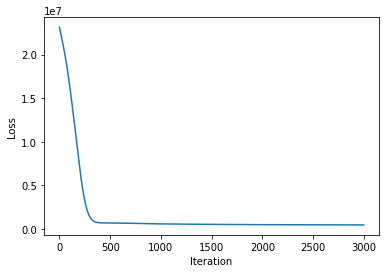

In [ ]:
train_loss = model.loss_curve_
plt.plot(range(len(train_loss)), train_loss)
train_loss[-1]
plt.xlabel('Iteration')
plt.ylabel('Loss')
#plt.xscale('log')
#plt.yscale('log')

In [ ]:
#manually test a single prediction
idx = 8
sample_x = np.array(test_x.iloc[idx, :]).reshape(1, -1)
model.predict(sample_x), test_y.iloc[idx]

(array([6246.27431017]), 6650.0)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but MLPRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


Text(0.5, 1.0, 'July MLP Regression (# of cyclists, Hadsundvej)')

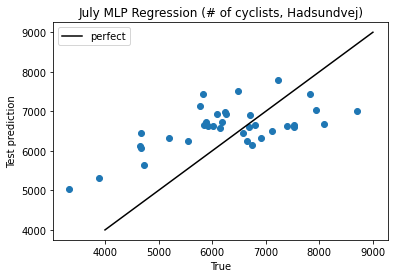

In [ ]:
#scatter test predictions against true cyclist counts
test_preds = model.predict(test_x)
plt.scatter(test_y, test_preds)
#plt.plot(range(4000, 9000), range(4000, 9000), label='perfect', color='black')
plt.xlabel('True')
plt.ylabel('Test prediction')
plt.legend()
plt.title('July MLP Regression (# of cyclists, Hadsundvej)')

Text(0.5, 1.0, 'July MLP Regression (# of cyclists, Hadsundvej)')

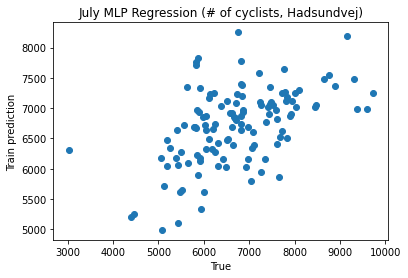

In [ ]:
#scatter training test predictions against true cyclist counts
train_preds = model.predict(train_x)
plt.scatter(train_y, train_preds)
plt.xlabel('True')
plt.ylabel('Train prediction')
plt.title('July MLP Regression (# of cyclists, Hadsundvej)')

In [ ]:
#fix nans in test data if necessary (if nan error in the plotting cells)
test_x = test_x.iloc[np.where((~np.isnan(test_x.pctpcp)) & (~np.isnan(test_x.pctmdt)) & (~np.isnan(test_x.pctsn)))[0]]
test_y = test_y.iloc[np.where((~np.isnan(test_x.pctpcp)) & (~np.isnan(test_x.pctmdt)) & (~np.isnan(test_x.pctsn)))[0]]
print(np.isnan(test_x).any())

mintmpf      False
maxtmpf      False
8amtmpf      False
4pmtmpf      False
maxdwpf      False
maxsknt      False
pctovc       False
meanrh       False
minalt       False
minvis       False
minfeel      False
maxfeel      False
pctpcp       False
pctmdt       False
pctsn        False
maxsdrct2    False
dtype: bool


    mintmpf  maxtmpf  8amtmpf  4pmtmpf  maxdwpf  maxsknt  pctovc     meanrh  \
34     55.4     66.2     57.2     66.2     59.0     11.0     0.0  85.135625   

    minalt  minvis  minfeel  maxfeel    pctpcp    pctmdt  pctsn  maxsdrct2  
34   29.44    1.24     55.4     66.2  4.166667  2.083333    0.0      280.0  
34 34    4680.0
Name: Hadsundvej, dtype: float64


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but MLPRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but MLPRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but MLPRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but MLPRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but MLPRegressor was fitted wi

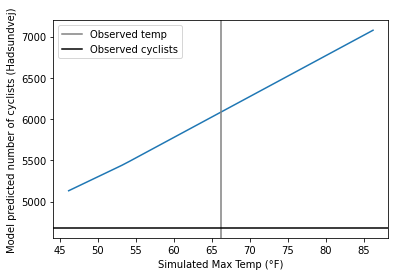

In [ ]:
#see how cyclist number prediction changes with max temp after selecting a random row
#probably not a good test b/c wx vars covary so much
rndrow = test_x.sample()
print(rndrow)
rowidx = rndrow.index[0]
rndanswer = test_y.loc[test_y.index == rowidx]
print(rowidx, rndanswer)

tmprange = 20 #one-sided temp chg
origtemp = rndrow.maxtmpf.values
testtemps = np.arange(origtemp - tmprange, origtemp + tmprange + 1, 1.0)
mdlin = [rndrow.copy() for i in range(testtemps.shape[0])]
for i in range(testtemps.shape[0]):
    mdlin[i].maxtmpf = testtemps[i]

preds = [model.predict(input) for input in mdlin]
plt.plot(testtemps, preds)
plt.xlabel('Simulated Max Temp (°F)')
plt.ylabel('Model predicted number of cyclists ({})'.format(baro))
plt.axvline(x=origtemp, label='Observed temp', color = 'gray')
plt.axhline(y=rndanswer.values, label='Observed cyclists', color = 'black')
plt.legend()

    mintmpf  maxtmpf  8amtmpf  4pmtmpf  maxdwpf  maxsknt  pctovc     meanrh  \
64     60.8     75.2     66.2     71.6     64.4     15.0     0.0  78.928085   

    minalt  minvis  minfeel  maxfeel  pctpcp  pctmdt  pctsn  maxsdrct2  
64   29.77    4.97     60.8     75.2     0.0     0.0    0.0      230.0  
64 64    6920.0
Name: Hadsundvej, dtype: float64


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but MLPRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but MLPRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but MLPRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but MLPRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but MLPRegressor was fitted wi

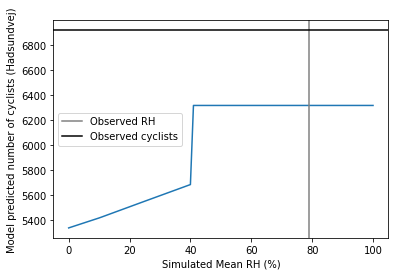

In [ ]:
#see how cyclist number prediction changes with meanrh after selecting a random row
#probably not a good test b/c wx vars covary so much
rndrow = test_x.sample()
print(rndrow)
rowidx = rndrow.index[0]
rndanswer = test_y.loc[test_y.index == rowidx]
print(rowidx, rndanswer)

origrh = rndrow.meanrh.values
testrh = np.arange(0, 101, 1.)
mdlin = [rndrow.copy() for i in range(testrh.shape[0])]
for i in range(testtemps.shape[0]):
    mdlin[i].meanrh = testrh[i]

preds = [model.predict(input) for input in mdlin]
plt.plot(testrh, preds)
plt.xlabel('Simulated Mean RH (%)')
plt.ylabel('Model predicted number of cyclists ({})'.format(baro))
plt.axvline(x=origrh, label='Observed RH', color = 'gray')
plt.axhline(y=rndanswer.values, label='Observed cyclists', color = 'black')
plt.legend()